## Problem 6.4

Let us define our domain: 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from copy import copy

# Domain parameters
L  = 100
dx = 0.1

# 1D Array holding grid points, x
x = np.arange(0, L+dx, dx)

# Number of grid points in x
N = len(x)

# Velocity (v) and stress (sigma)
v     = np.zeros(N)
sigma = np.zeros(N)

v_old = np.zeros(N)
s_old = np.zeros(N)

v_new = np.zeros(N)
s_new = np.zeros(N)

# Material properties - this is an array in so
# properties can be defined at each point in the grid
rho = np.zeros(N) + 1
mu  = np.zeros(N) + 1


### CFL Condition

We can use the CFL condition to determine our timestep. If we choose a Courant number of 0.5, this will be stable and set our timestep:

In [2]:
beta = np.sqrt(np.max(mu)/np.min(rho))
C = 0.5
dt = dx * C / beta

Define the initial condition as per the problem: 

In [3]:
def apply_initial_condition(x, v, sigma):
    # Equation 6.44
    sigma[:] = 0
    v = -0.2 * (x-50) * np.exp(-0.1*(x-50)**2)
    return v, sigma

### Solver:

The point of these methods is that they are flexible to whatever medium the wavefield is being simulated in. That is, the scheme is independent of whether the domain is homogeneous (part A of the problem) or heterogeneous (part B). Hence, we want to define a function that solves for the next timestep, which is relatively generic. 

At each grid point, the solver computes the new velocity and stress based on values from adjacent grid points. This can be written efficiently using arrays. Let us store the stress and velocity at each grid point in 1D arrays. The stress in the first grid point ($j=1$) will be stored in $\sigma$[0], and the stress in the second grid point in $\sigma[1]$ and so on.... Note here at Python indexing starts at 0 (like most programming languages, e.g. C++, Rust etc, while some others such as MATLAB start at 1!). If there are N grid points then the final stress value will be stored in $\sigma[N-1]$. 

Let us now consider the first point (away from the boundary) that we could apply our solver to, at the second ($j=2$) grid point. To update the velocity we know this would be: 

\begin{equation*}
v^{n+1}_{j=2} = v^{n-1}_{j=2} + \frac{\Delta t}{\Delta x \,\rho_{j=2}} \left( \sigma_{j=3}^n  - \sigma^n_{j=1}\right)
\end{equation*}

For now let us assume that we have access to the term $v^{n-1}_{j=2}$ which will be stored in a separate array, as well as the simulation parameters $\Delta t$, $\Delta x$. The important part to note is that we need access to the term $ \sigma_{j=3}^n  - \sigma^n_{j=1}$. Similarly, for the following $j$ values we need access to: 


\begin{align*}
j = 2 : \quad  &\sigma_{j=3}^n  - \sigma^n_{j=1}\\
j = 3 : \quad  &\sigma_{j=4}^n  - \sigma^n_{j=2}\\
j = 4 : \quad  &\sigma_{j=5}^n  - \sigma^n_{j=3}\\
j = 5 : \quad  &\sigma_{j=6}^n  - \sigma^n_{j=4}
\end{align*}

We may compute all of these at the same time, if we take two sub-arrays of $\sigma$ and subtract one from the other. The first array starts at the 3rd grid point ($j=3$) and represents the $\sigma^n_{j+1}$ values, while the second array starts at j=1 and represnts the $\sigma^n_{j+1}$ values. 

The point here is that for EACH point (excluding the boundary terms) we need to compute the difference of the terms either side of it, which can be done as an array subtraction, rather than in a loop where the computation must be done for each individual grid point in serial. 

To do this we use slicing, including negative slicing. Read more about this [here](https://www.w3schools.com/python/numpy/numpy_array_slicing.asp). 

In [4]:
def step_in_time(s_old, s, s_new, v_old, v, v_new, dx, dt, mu, rho, use_Dirichlet_BC):
    # Notes on slicing:
    # [1:-1] includes all points except boundaries
    # [2:  ] is from 3rd to end
    # [:-2 ] is from start to 3rd-last (missing last two points)

    # [1:-1] represents lower index = j
    # [2:  ] represents lower index = j + 1
    # [:-2 ] represents lower index = j - 1

    # Variable names (s and v):
    # s for sigma, v for v (velocity)
    # ? below means s or v
    # ?_new  represents superscript = n + 1
    # ?      represents superscript = n
    # ?_old  represents superscript = n - 1

    # Compute new v and s
    v_new[1:-1] = v_old[1:-1] + (dt / (rho[1:-1] * dx)) * (s[2:] - s[:-2])
    s_new[1:-1] = s_old[1:-1] + (dt * mu[1:-1] / dx) * (v[2:] - v[:-2])

    # Apply boundary conditions:
    if use_Dirichlet_BC:
        # Dirichlet:
        v_new[0] = 0
        v_new[-1] = 0

        # Use a 1-sided gradient approximation for the LHS edge:
        # sigma^(n+1)_j = sig^n_j + 2 dt mu_j  (v_1 - v_0) /dx
        # . where we know that v_0 is going to be 0
        # sigma^(n+1)_j = sig^n_j + 2 dt mu_j  (v_1 ) /dx
        s_new[0]  = s_old[0]  + 2 * dt * mu[0]  * v[1] / dx
        s_new[-1] = s_old[-1] + 2 * dt * mu[-1] * -v[-2] / dx
    else:
        s_new[0] = 0
        s_new[-1] = 0

        v_new[0] = v_old[0] + 2 * dt * s[1] / (dx * rho[0])
        v_new[-1] = v_old[-1] - 2 * dt * s[-2] / (dx * rho[-1])

    return v, v_new, s, s_new


Now we have defined a function to compute each timestep, let us finally run our simulation:

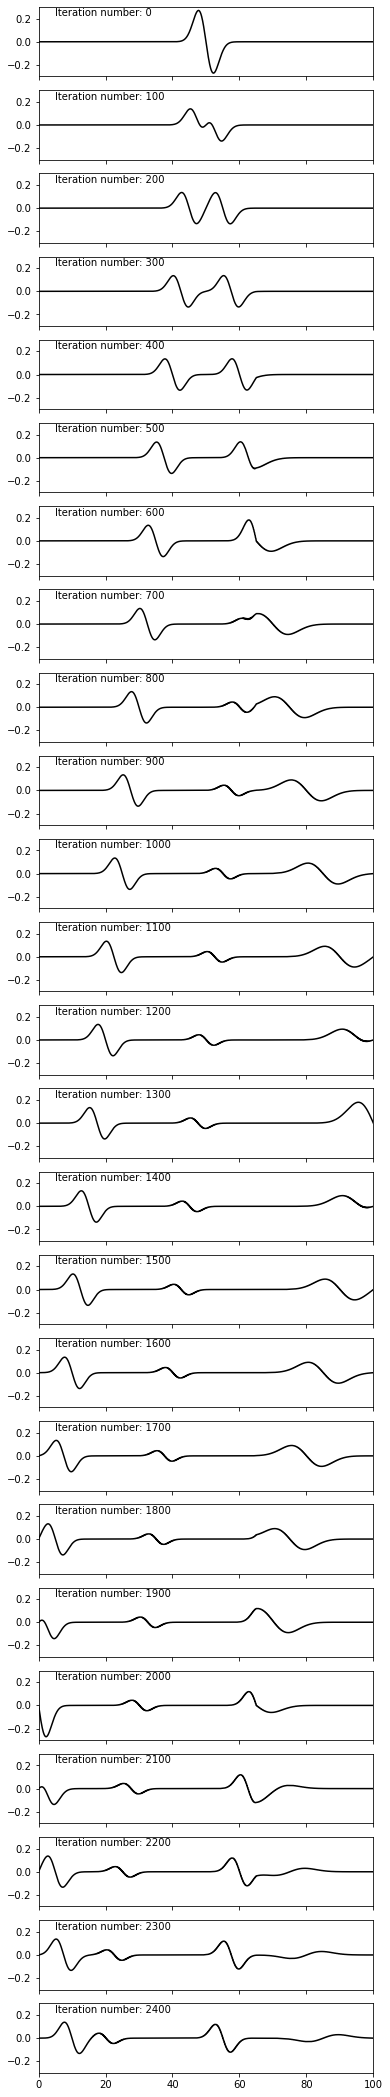

In [9]:
# Apply initial conditions
v, sigma     = apply_initial_condition(x, v, sigma)
v_old, s_old = apply_initial_condition(x, v_old, s_old)


# Number of timesteps and steps to plot
nsteps     = 2500
plot_every = 100
nplots     = nsteps//plot_every


# Create Figure
fig, ax = plt.subplots(nplots, figsize=(6,38), sharex=True, sharey=True)
iax = 0 

# Iterate through timesteps 
for i in range(nsteps):
    v, v_new, sigma, s_new = step_in_time(s_old=s_old, s=sigma, s_new=s_new,
                                      v_old=v_old, v=v, v_new=v_new,
                                      dx=dx, dt=dt, mu=mu, rho=rho,
                                      use_Dirichlet_BC=True)
    # Update timestep
    v_old = copy(v)
    s_old = copy(sigma)
    v     = copy(v_new)
    sigma = copy(s_new)

    if i%plot_every==0:
        ax[iax].plot(x, v, 'k')
        
        ax[iax].text(x=5, y = 0.22, s=f"Iteration number: {i}")
        ax[iax].set_xlim([0,100])
        ax[iax].set_ylim([-0.3,0.3])

        iax += 1

### Inhomogeneous Domain

Let us now consider the case of an inhomogeneous domain in which the shear modulus changes from $\mu = 1$ for $x \in [0,\,65]$ to $\mu = 4$ for $x \in [65,\,100]$.

In [6]:
# Velocity (v) and stress (sigma)
v     = np.zeros(N)
sigma = np.zeros(N)

v_old = np.zeros(N)
s_old = np.zeros(N)

v_new = np.zeros(N)
s_new = np.zeros(N)

# Material properties - this is an array in so
# properties can be defined at each point in the grid
rho = np.zeros(N) + 1
mu  = np.zeros(N) + 1

# For the region where x is greater than 65 we will now edit the shear values: 
mu[x > 65] = 4

Since we have changed our domain, we need to update our CFL condition and timestep

In [7]:
# We also need to update our CFL condition: 
beta = np.sqrt(np.max(mu)/np.min(rho))
C = 0.5
dt = dx * C / beta

Now let us re-run the simulation and see how the waves propagate. In this case, we will observe a reflected phase at the material interface ($x=65$) every time a wave interacts with it. 

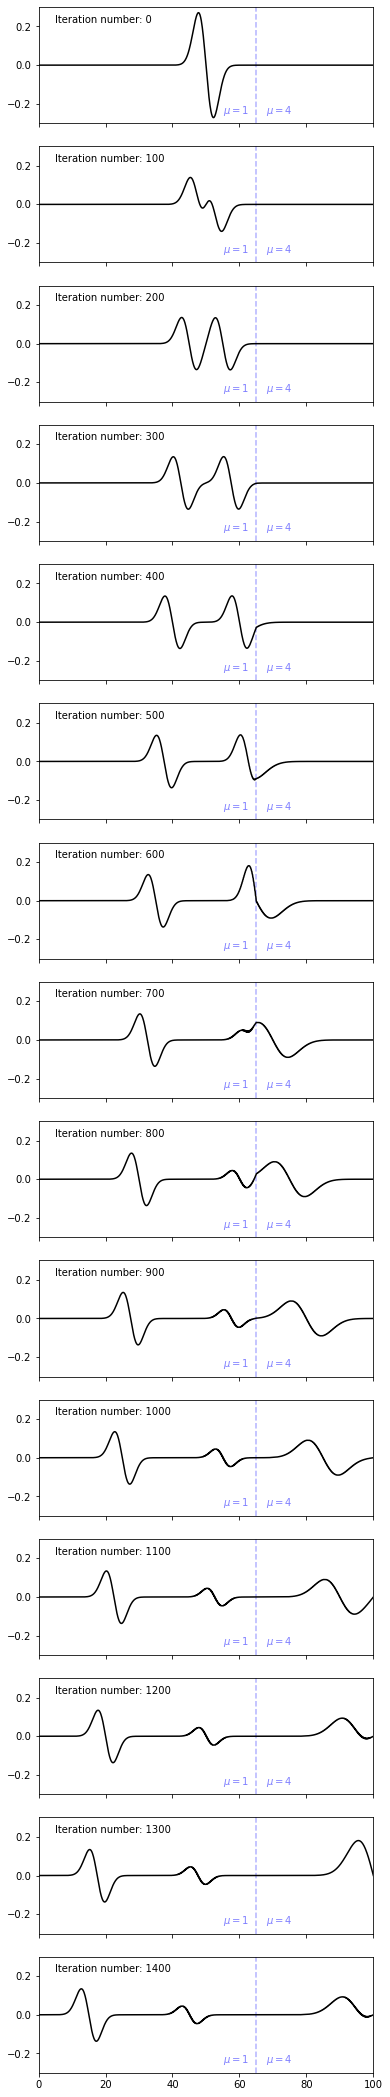

In [11]:
# Apply initial conditions
v, sigma     = apply_initial_condition(x, v, sigma)
v_old, s_old = apply_initial_condition(x, v_old, s_old)


# Number of timesteps and steps to plot
nsteps     = 1500
plot_every = 100
nplots     = nsteps//plot_every

# Create Figure
fig, ax = plt.subplots(nplots, figsize=(6,38), sharex=True, sharey=True)
iax = 0 

# Iterate through timesteps 
for i in range(nsteps):
    v, v_new, sigma, s_new = step_in_time(s_old=s_old, s=sigma, s_new=s_new,
                                      v_old=v_old, v=v, v_new=v_new,
                                      dx=dx, dt=dt, mu=mu, rho=rho,
                                      use_Dirichlet_BC=True)
    # Update timestep
    v_old = copy(v)
    s_old = copy(sigma)
    v     = copy(v_new)
    sigma = copy(s_new)

    if i%plot_every==0:
        
        # Plot a line at x=65 and add annotation
        ax[iax].axvline(65, alpha=0.3, linestyle='--', color='blue')
        ax[iax].text(x=55, y = -0.25, s=r"$\mu = 1$", color='blue', alpha=0.5)
        ax[iax].text(x=68, y = -0.25, s=r"$\mu = 4$", color='blue', alpha=0.5)

        ax[iax].plot(x, v, 'k')
        
        ax[iax].text(x=5, y = 0.22, s=f"Iteration number: {i}")
        ax[iax].set_xlim([0,100])
        ax[iax].set_ylim([-0.3,0.3])

        
        iax += 1
